Luca Domeniconi luca.domeniconi5@studio.unibo.it (student-id: 0001113308)

-------

# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.


CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.
* No postprocessing should be done (e.g. no beamsearch)
* You cannot use additional training data.


BONUS PARAMETERS:

A bonus of 0-2 points will be attributed to incentivate the adoption of models with a low number of parameters.

# Dataset

The dataset is composed by sentences taken from the generics_kb dataset of hugging face. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary.

In [ ]:
!pip install datasets

Download the dataset

In [4]:
from datasets import load_dataset
from keras.layers import TextVectorization
import tensorflow as tf
import numpy as np
import pickle

SEED = 24
np.random.seed(SEED)

Create a tokenizer and Detokenizer

In [5]:
class TextDetokenizer:
        def __init__(self, vectorize_layer):
                self.vectorize_layer = vectorize_layer
                vocab = self.vectorize_layer.get_vocabulary()
                self.index_to_word = {index: word for index, word in enumerate(vocab)}

        def __detokenize_tokens(self, tokens):
                def check_token(t):
                    if t == 3:
                        s="<start>"
                    elif t ==2:
                        s="<end>"
                    elif t ==7:
                        s="<comma>"
                    else:
                        s=self.index_to_word.get(t, '[UNK]')
                    return s

                return ' '.join([ check_token(token) for token in tokens if token != 0])

        def __call__(self, batch_tokens):
             return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]

# check if the tokenizer is already saved
try:
    print("Loading tokenizer and original data.")
    # Load the tokenizer with pickle
    with open('tokenizer.pkl', 'rb') as f:
        tokenizer_data = pickle.load(f)
        tokenizer = TextVectorization.from_config(tokenizer_data["config"])
        tokenizer.set_weights(tokenizer_data["weights"])
        detokenizer = TextDetokenizer( tokenizer )
    
    # Read original_data with pickle
    with open('original_data.pkl', 'rb') as f:
        original_data = pickle.load(f)
    
except FileNotFoundError:
    print("Tokenizer or original data not found. Creating new ones.")
    # Create a new tokenizer
    ds = load_dataset('generics_kb',trust_remote_code=True)['train']
    ds = ds.filter(lambda row: len(row['generic_sentence'].split(" "))>8 )
    corpus = [ '<start> ' + row['generic_sentence'].replace(","," <comma>") + ' <end>' for row in ds ]
    corpus = np.array(corpus)
    tokenizer=TextVectorization( max_tokens=10000, standardize="lower_and_strip_punctuation")
    tokenizer.adapt(corpus)
 
 
    detokenizer = TextDetokenizer( tokenizer )
    sentences = tokenizer( corpus ).numpy()
 
    mask = np.sum( (sentences==1) , axis=1) >= 1
    original_data = np.delete( sentences, mask , axis=0)
    original_data = [sen for sen in tokenizer(corpus).numpy() if not(1 in sen) and len(sen)>4 and len(sen)<= 32]
 
# Shuffle the original_data
shuffled_indices = np.random.permutation(len(original_data))
original_data = np.array(original_data)[shuffled_indices]

Loading tokenizer and original data.



Create the DataGenerator

In [6]:
from keras.utils import Sequence

class DataGenerator(Sequence):
        def __init__(self, data, batch_size=32, shuffle=True, seed=None):

            self.data = data
            self.batch_size = batch_size
            self.shuffle = shuffle
            self.seed = seed
            self.on_epoch_end()

        def __len__(self):
            return int(np.floor(len(self.data) / self.batch_size))

        def __getitem__(self, index):
            indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

            data_batch = np.array([self.data[k] for k in indexes])
            #cop of ordered sequences
            result = np.copy(data_batch)
            #shuffle only the relevant positions for each batch
            for i in range(data_batch.shape[0]):
                np.random.shuffle(data_batch[i,1:data_batch[i].argmin() - 1])

            return data_batch , result

        def on_epoch_end(self):
            self.indexes = np.arange(len(self.data))
            if self.shuffle:
                if self.seed is not None:
                    np.random.seed(self.seed)
                np.random.shuffle(self.indexes)

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/max(|s|,|p|)

If the match is exact, the score is 1.

When computing the score, you should NOT consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [7]:
from difflib import SequenceMatcher

def score(s,p):
    match = SequenceMatcher(None, s, p).find_longest_match()
    return (match.size/max(len(p),len(s)))

Let's do an example.

In [12]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


In [13]:
print(score("2 1 20 3 0 0", "2 20 1 3 0 0"))

0.5


The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented.
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training.
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

For this project I implemented a Transformer model based on the [Tensorflow implementation](https://www.tensorflow.org/text/tutorials/transformer), that follows the original paper ["Attention Is All You Need"](https://arxiv.org/pdf/1706.03762).

The transformer takes as input two values:
1) `Context`: contains the scrambled phrase, it is fed into the input of the Encoder and has a shape of (`batch_size`, `max_len`) 
2) `x`: contains the input of the Decoder and has a shape of (`batch_size`, `max_len`).

The transformer output has the following shape:

(`batch_size`, `max_len`, `max_len`)

and contains for each position the probability of the next token to be the $i$-th token in the `Context`. Basically, instead of outputting a probability for each word in the dictionary, it outputs the probability for each token in the `Context` to be the next token in the prediction. In this way, the model can only output words from the `Context` and not words from the entire dictionary, making it easier to train.


During the training phase, `x` contains the ground truth (ordered phrase). During the inference phase, `x` contains initially only the `<start>` token, and each call to the model generates a new token that gets appended.

In [8]:
import tensorflow as tf
from keras.layers import MultiHeadAttention, LayerNormalization, Add, Embedding, Dense, Dropout, Layer
from keras import Sequential, Model
import numpy as np
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam, AdamW

class BaseAttention(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = MultiHeadAttention(**kwargs)
        self.layernorm = LayerNormalization()
        self.add = Add()
        
class CrossAttention(BaseAttention):
    def call(self, x, context):
        x = tf.cast(x, tf.float64)
        context = tf.cast(context, tf.float64)
        attn_output, attn_scores = self.mha(
                query=x,
                key=context,
                value=context,
                return_attention_scores=True)

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

class GlobalSelfAttention(Layer):
    def __init__(self, num_heads, key_dim, dropout):
        super().__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=dropout)
        self.layernorm = LayerNormalization()
        self.add = Add()
        
    def call(self, x):
        x = tf.cast(x, tf.float64)
        attn_output = self.mha(
                query=x,
                value=x,
                key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class CausalSelfAttention(BaseAttention):
    def call(self, x):
        x = tf.cast(x, tf.float64)
        attn_output = self.mha(
                query=x,
                value=x,
                key=x,
                use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]         # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth     # (1, depth)

    angle_rates = 1 / (10000**depths)                 # (1, depth)
    angle_rads = positions * angle_rates            # (pos, depth)

    pos_encoding = np.concatenate(
            [np.sin(angle_rads), np.cos(angle_rads)],
            axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(Layer):
    def __init__(self, vocab_size, d_model, max_len):
        super().__init__()
        self.d_model = d_model
        self.embedding = Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)
        self.max_len = max_len

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = self.max_len
        # length = x.shape[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        pos_encoding = positional_encoding(length, self.d_model)
        x = x + pos_encoding[tf.newaxis, :length, :]

        return x

class FeedForward(Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = Sequential([
            Dense(dff, activation='swish'),
            Dense(d_model),
            Dropout(dropout_rate)
        ])
        self.add = Add()
        self.layer_norm = LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

class EncoderLayer(Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = GlobalSelfAttention(
                num_heads=num_heads,
                key_dim=d_model,
                dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)        
        x = self.ffn(x)
        return x
    
class Encoder(Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,max_len, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model, max_len=max_len)

        self.enc_layers = [
                EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
                for _ in range(num_layers)]
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)    # Shape `(batch_size, seq_len, d_model)`.
        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x    # Shape `(batch_size, seq_len, d_model)`.

class DecoderLayer(Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
                num_heads=num_heads,
                key_dim=d_model,
                dropout=dropout_rate)

        self.cross_attention = CrossAttention(
                num_heads=num_heads,
                key_dim=d_model,
                dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        x = self.ffn(x)    # Shape `(batch_size, seq_len, d_model)`.
        return x

class Decoder(Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, max_len,
                             dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model, max_len=max_len)
        self.dropout = Dropout(dropout_rate)
        self.dec_layers = [
                DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
                for _ in range(num_layers)]

    def call(self, x, context):
        x = self.pos_embedding(x)    # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x, context)

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

class Transformer(Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
                             input_vocab_size, target_vocab_size,output_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                                                     num_heads=num_heads, dff=dff,
                                                     vocab_size=input_vocab_size,
                                                     dropout_rate=dropout_rate,
                                                     max_len=output_vocab_size)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                                                     num_heads=num_heads, dff=dff,
                                                     vocab_size=target_vocab_size,
                                                     dropout_rate=dropout_rate,
                                                     max_len=output_vocab_size)

        self.final_layer = Dense(output_vocab_size)

    def call(self, inputs):
        # Shape of inputs is (context, x), where context is the input text and x is the target text.
        context, x = inputs

        context = self.encoder(context)    # (batch_size, context_len, d_model)

        x = self.decoder(x, context)    # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)    # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

## Custom generator

The label used in training has the following shape:

(`batch_size`, `max_len`, `max_len`)

and is the one-hot encoding of the positions of the next correct token from the `Context`.

**Example:** If $G_t$ contains the ground truth and $S$ contains the scrambled phrase the label used in training would be:

$S = [2,101,102,103,3,0]$

$G_t = [2,103,101,102,3,0]$

$ Label = \begin{bmatrix}1,0,0,0,0,0 \\\
		  0,0,0,1,0,0 \\\
0,1,0,0,0,0 \\\
0,0,1,0,0,0 \\\
0,0,0,0,1,0 \\\
0,0,0,0,0,0 \end{bmatrix}$


In [9]:
def generate_label(shuffled,gt):
    batch_size = shuffled.shape[0]
    res = np.zeros((batch_size, shuffled.shape[1], shuffled.shape[1]), dtype=np.float32)
    for b in range(batch_size):
        for i, el in enumerate(gt[b]):
            if el == 0:
                # If the element is 0, then the rest of the sequence is padding.
                mask = np.zeros_like(gt[b], dtype=np.float32)
            else:
                # Create a mask with 1s up to the element we want to predict.
                mask = (shuffled[b]==el).astype(np.float32)
                # If there are multiple occurrences of the element, keep only the first one.
                idx = np.where(mask == 1)[0][0] + 1
                mask[idx:] = 0                

            res[b][i] = mask
    return res                

"""
New data generator that generates the label based on the generated x and y.
"""
class DataGeneratorWrapper(DataGenerator):
    def __getitem__(self, index):
        x, y = super().__getitem__(index)
        # Remove the end token from the input.
        y_without_end = y.copy()
        y_without_end[y == 2] = 0
        
        y_left_shifted = np.roll(y, -1, axis=1)
        label = generate_label(x, y_left_shifted)
        return (x, y), label

## Training

### Hyperparameters


For the model, the following hyperparameter have been used:

- `num_layers` -> **$4$** (number of Encoder and Decoder layers)
- `d_model` -> **$172$** (dimension of the token embedding inside the model)
- `num_heads` -> **$10$** (number of attention heads in each attention block)
- `dff` -> **$512$** (neurons inside a feed forward layer)
- `max_length` -> **$32$** (max lenght of each input phrase)
- `input_vocab_size` -> **$10\,000$** (size of the input vocabolary)
- `target_vocab_size` -> **$10\,000$** (size of the target vocabolary)
- `output_vocab_size` -> **$28$** (size of the output vocabolary)
- `train_size` -> **$220\,000$** (dimension of the train set)
- `validation_size` -> **$3000$** (dimension of the validation set)
- `epochs` -> **$64$** (epochs used to train the model)
- `learning_rate` -> **$10^{-4}$** (for some learning rate scheduler it varies)
- `lr_scheduler` -> **"constant"** (learning rate scheduler)
- `warmup_steps` -> **Not used** (warmup steps used in some learning rate scheduler)
- `weight_decay` -> **$10^{-3}$** (weight decay used in loss function)
- `optimizer` -> **"adamw"** (optimizer used in training)
- `loss` -> **"categorical_crossentropy"** (loss used in training)

### Training method

The laptop used to write this code doesn't have a GPU so to train the model I used another machine and logged all the results and saved the resulting models using [Weights & Biases](http://wandb.ai).

In [ ]:
!pip install wandb

In [10]:
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

USE_WANDB = True
DOWNLOAD_MODEL = True
MODEL_TO_DOWNLOAD = 'luca24ever_unibo/DLAssignment/run_hry16xff_model:latest' # Name of the trained model from wandb
CONTINUE_TRAINING = False

input_vocab_size = tokenizer.vocabulary_size()
output_vocab_size = max([len(sen) for sen in original_data]) # Should be 28

config = {
    "num_layers": 4,
    "d_model": 172,
    "num_heads": 10,
    "dff": 512,
    "max_length": 32,
    "train_size": 220000,
    "validation_size": 3000,
    "batch_size": 32,
    "learning_rate": 1e-4,
    "weight_decay": 1e-3,
    "epochs": 63,
    "optimizer": "adamw",
    "loss": "categorical_crossentropy",
    "input_vocab_size": input_vocab_size,
    "target_vocab_size": input_vocab_size,
    "output_vocab_size": output_vocab_size,
    "lr_scheduler": "constant",
    "warmup_steps": 1000,
}

if USE_WANDB:
    run = wandb.init(
        # set the wandb project where this run will be logged
        project="DLAssignment",
        # track hyperparameters and run metadata with the config object
        config=config
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: luca24ever (luca24ever_unibo). Use `wandb login --relogin` to force relogin


## Model Definition

The model is composed of $19\,130\,524$ trainable params.

In [11]:
transformer = Transformer(num_layers=config["num_layers"],
                          d_model=config["d_model"],
                          num_heads=config["num_heads"],
                          dff=config["dff"],
                          input_vocab_size=config["input_vocab_size"],
                          target_vocab_size=config["target_vocab_size"],
                          output_vocab_size=config["output_vocab_size"])

In [13]:
# Continue with the previous training
if DOWNLOAD_MODEL and USE_WANDB:
    MODEL_NAME = "transformer_model.h5"

    # Download the model from wandb
    artifact = run.use_artifact(MODEL_TO_DOWNLOAD, type='model')
    artifact_dir = artifact.download()

    # Load the downloaded weights into the model
    transformer.build(input_shape=[(None, None), (None, None)])
    transformer.load_weights(artifact_dir + "/" + MODEL_NAME)

wandb: Downloading large artifact run_hry16xff_model:latest, 73.20MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


## Training

Different Learning Rate scheduler had been tested and the best one was found to be the costant scheduler.

In [14]:
class BatchLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, schedule):
        super(BatchLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_train_batch_begin(self, batch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        scheduled_lr = self.schedule(batch, lr)
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, scheduled_lr)
        
def lr_schedule_decay(batch, lr):
    initial_lr = 0.001
    k = 0.0001
    return initial_lr * np.exp(-k * batch)

def lr_schedule_constant(batch, lr):
    return lr

def lr_schedule_transformer(batch, lr):
    initial_lr = 0.001
    warmup_steps = 4000
    step_num = batch + 1  # Avoid division by zero
    return initial_lr * min(step_num**-0.5, step_num * (warmup_steps**-1.5))

In [15]:
# Define all the generators
train_generator = DataGeneratorWrapper(original_data[:config["train_size"]-config["validation_size"]], batch_size=config["batch_size"], seed=SEED)
validation_generator = DataGeneratorWrapper(original_data[config["train_size"]-config["validation_size"]:config["train_size"]], batch_size=config["batch_size"], shuffle=False, seed=SEED)
test_generator = DataGeneratorWrapper(original_data[config["train_size"]:], batch_size=config["batch_size"], shuffle=False, seed=SEED)

In [ ]:
if CONTINUE_TRAINING:
    # Choose the optimizer based on the configuration
    if config["optimizer"] == "adam":
        optimizer = Adam(learning_rate=config["learning_rate"])
    elif config["optimizer"] == "adamw":
        optimizer = AdamW(learning_rate=config["learning_rate"], weight_decay=config["weight_decay"])
    else:
        raise ValueError(f'Unknown optimizer: {config["optimizer"]}')

    # Choose the loss function based on the configuration
    if config["loss"] == "categorical_crossentropy":
        loss = CategoricalCrossentropy(from_logits=True)
    else:
        raise ValueError(f'Unknown loss: {config["loss"]}')

    # Choose the learning rate scheduler based on the configuration
    if config["lr_scheduler"] == "constant":
        lr_schedule = lr_schedule_constant
    elif config["lr_scheduler"] == "decay":
        lr_schedule = lr_schedule_decay
    elif config["lr_scheduler"] == "transformer":
        lr_schedule = lr_schedule_transformer
    else:
        raise ValueError(f'Unknown lr_scheduler: {config["lr_scheduler"]}')

    lr_scheduler = BatchLearningRateScheduler(lr_schedule)

    # Compile the model with the chosen optimizer and loss function
    transformer.compile(optimizer=optimizer, loss=loss)

    # Train the model with the specified number of epochs and validation data
    # and logs the metrics to wandb
    if USE_WANDB:
        transformer.fit(train_generator, epochs=config["epochs"], validation_data=validation_generator, callbacks=[
            WandbMetricsLogger(log_freq=5),
            WandbModelCheckpoint("transformer_model.h5", monitor="val_loss", save_best_only=True, save_weights_only=True),
            lr_scheduler
        ])
    else:
        transformer.fit(train_generator, epochs=config["epochs"], validation_data=validation_generator, callbacks=[
            lr_scheduler
        ])

    # Save the trained model
    transformer.save('transformer.h5')

**Note**: the output logs of the training are not printed in this notebook because the model was trained on another device. The relevant data are plotted below.

In [16]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  7184768   
                                                                 
 decoder (Decoder)           multiple                  11940912  
                                                                 
 dense_16 (Dense)            multiple                  4844      
                                                                 
Total params: 19130524 (72.98 MB)
Trainable params: 19130524 (72.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train plots

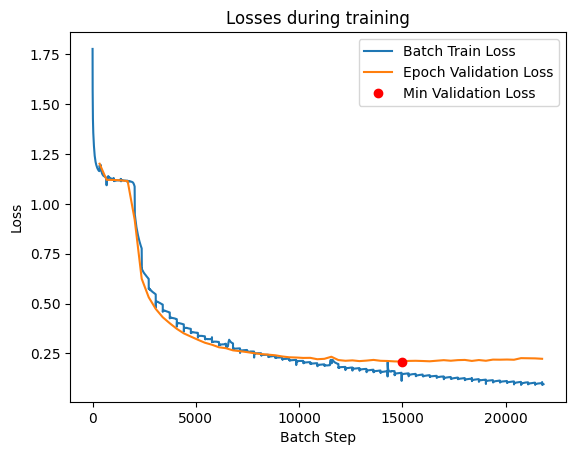

In [17]:
import json
import matplotlib.pyplot as plt

with open("data.json") as f:
	data = json.load(f)

plt.title("Losses during training")
plt.xlabel("Batch Step")
plt.ylabel("Loss")
plt.plot(data["data_batch_loss"]["steps"], data["data_batch_loss"]["loss"], label="Batch Train Loss")

plt.plot(data["data_val_loss"]["steps"], data["data_val_loss"]["loss"], label="Epoch Validation Loss")
plt.plot(data["data_val_loss"]["steps"][data["arg_min_val_loss"]], data["min_val_loss"], 'ro', label="Min Validation Loss")
plt.legend()
plt.show()

**Note**: the step-like trend of the batch train loss is due to a Keras implementation of the logging, because instead of printing the current value of the loss function, it prints the average of the loss from the start of the epoch.

**Links**: here I link the plots above directly from Weights & Biases:
- [Batch Train Loss](https://api.wandb.ai/links/luca24ever_unibo/hhgp9y16)
- [Epoch Val Loss](https://api.wandb.ai/links/luca24ever_unibo/xkcyxcat)

# Evaluation

To predict the resulting sentence, only the `<start>` token is fed inside the Decoder and the reordered sentence is fed inside the Encoder. The prediction is made one token at a time that gets appended to the input of the Decoder. The process ends when the model predicts the index of the `<end>` token in the input sentence.  

The given score function is used to evaluate the model. The predicted sentence is compared to the ground truth sentence and the strings `<start>` and `<end>` are removed from both.

For the inference, a masking mechanism have also been implemented, basically setting to $-\infty$ all the values of the predictions for the tokens that has already been chosen in order to constraint the output of the network to not choose the same word two times.

Nevertheless, post-processing of the output is not allowed in this task, so the variable `USE_MASK` is set to false.

In [22]:
import keras
from tqdm import tqdm
import gc

START_TOKEN = 3
END_TOKEN = 2
PADDING_TOKEN = 0

def calculate_avg_score(transformer, test_generator, detokenizer, use_mask=False):
    scores = []
    
    # The ground truth labels are ignored in evaluation
    for (input_tokens, truth_tokens), _ in tqdm(test_generator):
        batch_size = truth_tokens.shape[0]
        truth_sents = [ detokenizer([truth_tokens[b]])[0] for b in range(batch_size) ]
        prediction_sentence = [""] * batch_size
        prediction_tokens = np.array([[START_TOKEN] + [PADDING_TOKEN] * 27] * batch_size)
        
        masks = np.zeros((batch_size, 28, 28))

        for i in range(27):
            out = transformer.predict_on_batch(( np.array(input_tokens), np.array(prediction_tokens) ))

            if use_mask:
                out = out + masks

            for b in range(batch_size):
                # If the sentence has already been predicted, skip it
                if len(prediction_sentence[b]) != 0: continue
                
                predicted_token_index = np.argmax(out[b, i, :])
                predicted_token = input_tokens[b, predicted_token_index]
                
                if use_mask:
                    # Find the number of occurences of pred_token inside in_tokens[b]
                    occurences_input = np.sum(input_tokens[b] == predicted_token)
                    occurences_autoregressive = np.sum(prediction_tokens[b] == predicted_token)
                    
                    # If the predicted token has already been predicted more times than it appears in the input, mask it
                    if occurences_autoregressive >= occurences_input:
                        masks[b, :, predicted_token_index] = - np.inf
                
                prediction_tokens[b, i+1] = predicted_token

                # If the predicted token is the end token, stop the prediction
                if predicted_token == END_TOKEN:
                    prediction_sentence[b] = detokenizer([prediction_tokens[b]])[0]
            
            # If all the sentences have been predicted, stop the prediction
            if all([ len(s) > 0 for s in prediction_sentence ]):
                break

        # Handle sentences without end token
        for b in range(len(prediction_sentence)):
            if len(prediction_sentence[b]) == 0:
                prediction_sentence[b] = detokenizer([prediction_tokens[b]])[0] + " <end>"
        
        for b in range(batch_size):
            # Remove <start> and <end> tokens
            prediction_sentence[b], truth_sents[b] = prediction_sentence[b][8:-6], truth_sents[b][8:-6] 
            scores.append( score(truth_sents[b], prediction_sentence[b]) )

        # Fix memory leak
        gc.collect()
        keras.backend.clear_session()
        
    return len(scores), np.mean(scores), np.std(scores)

In [23]:
num_scores, avg_score, std_score = calculate_avg_score(transformer, test_generator, detokenizer, use_mask=False)
print(f"\nNumber of test sentences: {num_scores}")
print(f"Average score: {avg_score}")
print(f"Standard deviation of the scores: {std_score}")

100%|██████████| 663/663 [34:09<00:00,  3.09s/it]


Number of test sentences: 21216
Average score: 0.6503331317989776
Standard deviation of the scores: 0.31162338368881815


### Average Score: $0.6503331317989776$